### Stock Market Prediction And Forecasting Using Stacked LSTM

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import precision_score, make_scorer

In [20]:
# READ THE 6H DATA
data_1h=pd.read_json('/content/response_1h')
data_1h['startTime']=pd.to_datetime(data_1h['startTime'],unit='ms')
data_1h.sort_values('startTime',inplace=True)
data_1h.set_index('startTime',inplace=True)
data_1h.head()

,open,high,low,close,endTime,volume
startTime,,,,,,
2024-07-25 19:00:00,5646332,5684910,5631080,5656315,1721937599999,687.869
2024-07-25 20:00:00,5657077,5710872,5633443,5709340,1721941199999,729.368
2024-07-25 21:00:00,5709340,5772218,5702200,5757614,1721944799999,1159.287
2024-07-25 22:00:00,5756905,5785842,5739616,5740132,1721948399999,545.354
2024-07-25 23:00:00,5740132,5755260,5738758,5753248,1721951999999,208.241


In [21]:
open,high,low,close=data_1h[['open']].copy(),data_1h[['high']].copy(),data_1h[['low']].copy(),data_1h[['close']].copy()
open.head()

,open
startTime,
2024-07-25 19:00:00,5646332
2024-07-25 20:00:00,5657077
2024-07-25 21:00:00,5709340
2024-07-25 22:00:00,5756905
2024-07-25 23:00:00,5740132


In [22]:
open.to_csv('open_1h.csv')
high.to_csv('high_1h.csv')
low.to_csv('low_1h.csv')
close.to_csv('close_1h.csv')

In [23]:
data_1h.drop(['endTime'],axis=1,inplace=True)

In [24]:
data_1h.drop(['volume'],axis=1,inplace=True)

In [25]:
data_1h.head()

,open,high,low,close
startTime,,,,
2024-07-25 19:00:00,5646332,5684910,5631080,5656315
2024-07-25 20:00:00,5657077,5710872,5633443,5709340
2024-07-25 21:00:00,5709340,5772218,5702200,5757614
2024-07-25 22:00:00,5756905,5785842,5739616,5740132
2024-07-25 23:00:00,5740132,5755260,5738758,5753248


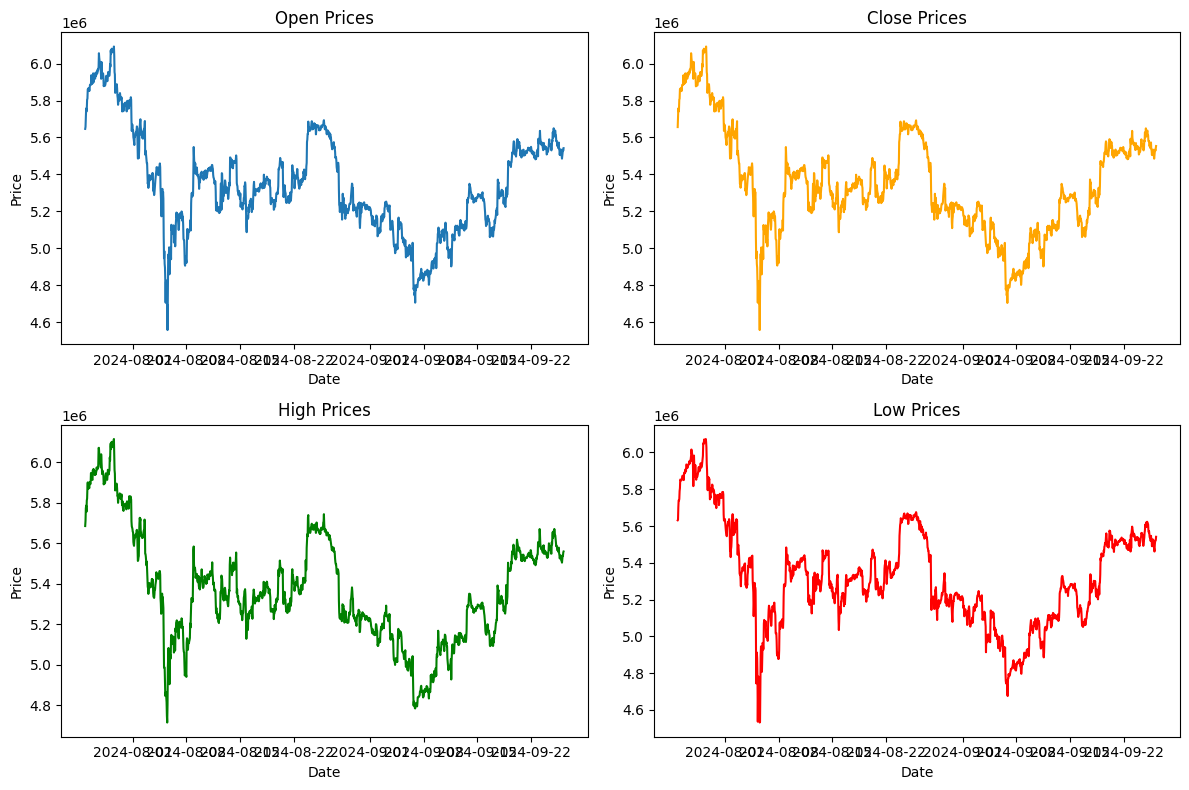

In [26]:
# PLOT THE GRAPH OF open, close, high, low TO SEE THEIR BEHAVIOR
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# PLOT 'open'
axs[0, 0].plot(data_1h.index, data_1h['open'], label='Open')
axs[0, 0].set_title('Open Prices')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')

# PLOT 'close'
axs[0, 1].plot(data_1h.index, data_1h['close'], label='Close', color='orange')
axs[0, 1].set_title('Close Prices')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')

# PLOT 'high'
axs[1, 0].plot(data_1h.index, data_1h['high'], label='High', color='green')
axs[1, 0].set_title('High Prices')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')

# PLOT 'low'
axs[1, 1].plot(data_1h.index, data_1h['low'], label='Low', color='red')
axs[1, 1].set_title('Low Prices')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')

plt.tight_layout()
plt.show()

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [ ]:
import numpy as np

In [12]:
data_1h.head()

,open,high,low,close
startTime,,,,
2024-07-25 19:00:00,5646332,5684910,5631080,5656315
2024-07-25 20:00:00,5657077,5710872,5633443,5709340
2024-07-25 21:00:00,5709340,5772218,5702200,5757614
2024-07-25 22:00:00,5756905,5785842,5739616,5740132
2024-07-25 23:00:00,5740132,5755260,5738758,5753248


In [13]:
data=data_1h.copy()

In [14]:

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(data)

In [15]:
print(df1)

[[0.70944107 0.6930058  0.71330105 0.71584459]
 [0.71644278 0.71155535 0.7148334  0.75040937]
 [0.75049866 0.75538635 0.75942075 0.78187717]
 ...
 [0.63649882 0.58717651 0.64113849 0.63241261]
 [0.63276566 0.59993584 0.64246463 0.64183652]
 [0.64149352 0.60328822 0.65513069 0.64907866]]


In [16]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [17]:
training_size,test_size

(975, 525)

In [18]:
train_data

array([[0.70944107, 0.6930058 , 0.71330105, 0.71584459],
       [0.71644278, 0.71155535, 0.7148334 , 0.75040937],
       [0.75049866, 0.75538635, 0.75942075, 0.78187717],
       ...,
       [0.2735652 , 0.22566471, 0.28757894, 0.29998123],
       [0.30089436, 0.22672715, 0.31098897, 0.30182142],
       [0.3020132 , 0.22443793, 0.30634587, 0.29176586]])

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
for price in ['open', 'close', 'high', 'low']:

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 487ms/step - loss: 0.0206 - val_loss: 0.0505
Epoch 2/100
12/12 [==============================] - 4s 309ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 3/100
12/12 [==============================] - 4s 300ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 4/100
12/12 [==============================] - 3s 287ms/step - loss: 8.1361e-04 - val_loss: 0.0073
Epoch 5/100
12/12 [==============================] - 3s 290ms/step - loss: 6.6860e-04 - val_loss: 0.0062
Epoch 6/100
12/12 [==============================] - 3s 255ms/step - loss: 6.4653e-04 - val_loss: 0.0062
Epoch 7/100
12/12 [==============================] - 3s 291ms/step - loss: 6.6186e-04 - val_loss: 0.0062
Epoch 8/100
12/12 [==============================] - 4s 300ms/step - loss: 6.2498e-04 - val_loss: 0.0049
Epoch 9/100
12/12 [==============================] - 4s 297ms/step - loss: 6.2745e-04 - val_loss: 0.0042
Epoch 10/100
12/12 [==============================] - 4s 303ms/step

12/12 [==============================] - 3s 282ms/step - loss: 1.7841e-04 - val_loss: 0.0014
Epoch 79/100
12/12 [==============================] - 3s 260ms/step - loss: 1.9611e-04 - val_loss: 0.0013
Epoch 80/100
12/12 [==============================] - 3s 281ms/step - loss: 2.0224e-04 - val_loss: 0.0012
Epoch 81/100
12/12 [==============================] - 3s 290ms/step - loss: 2.1049e-04 - val_loss: 0.0020
Epoch 82/100
12/12 [==============================] - 3s 288ms/step - loss: 1.9466e-04 - val_loss: 0.0010
Epoch 83/100
12/12 [==============================] - 3s 284ms/step - loss: 1.5801e-04 - val_loss: 0.0010
Epoch 84/100
12/12 [==============================] - 3s 272ms/step - loss: 1.6260e-04 - val_loss: 9.4397e-04
Epoch 85/100
12/12 [==============================] - 3s 249ms/step - loss: 1.5695e-04 - val_loss: 0.0013
Epoch 86/100
12/12 [==============================] - 3s 242ms/step - loss: 2.0192e-04 - val_loss: 9.7445e-04
Epoch 87/100
12/12 [==============================]

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.1.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

140.9909210035748

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

235.7193088627771

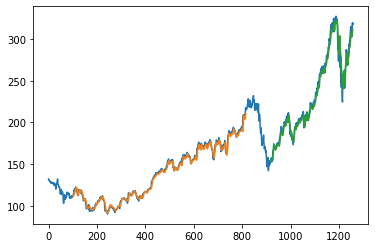

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

441

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.94413203]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.

10 day output [[0.9050924]]
11 day input [0.94950604 0.96424048 0.95512117 0.95989192 0.96635143 0.96246728
 0.92295027 0.9598497  0.98792536 0.98594106 0.92531453 0.92172591
 0.96474711 0.97572406 0.99159841 0.96972895 0.97614625 0.96795575
 1.         0.99016297 0.99050072 0.96538039 0.98488559 0.97086887
 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273
 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725
 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371
 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494
 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402
 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832
 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543
 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148
 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415
 0.92793211 0.948535   0.93333615 0.91746179 0.92544119 0.91771511
 0.9483239  0.9406400

20 day output [[0.90279734]]
21 day input [0.92531453 0.92172591 0.96474711 0.97572406 0.99159841 0.96972895
 0.97614625 0.96795575 1.         0.99016297 0.99050072 0.96538039
 0.98488559 0.97086887 0.94026007 0.87748037 0.83483915 0.85413324
 0.77336823 0.77269273 0.88014017 0.84007431 0.89673225 0.85527316
 0.83884995 0.74233725 0.82327113 0.78143207 0.6665963  0.7921557
 0.64118044 0.68614371 0.66001013 0.65203074 0.58642236 0.56586169
 0.66089673 0.65515494 0.70970193 0.66452757 0.69437642 0.69218104
 0.63569197 0.65266402 0.63780292 0.7267162  0.71388162 0.74191506
 0.75002111 0.77222832 0.83049059 0.8194292  0.8289707  0.8125475
 0.78776492 0.75162543 0.78426074 0.77974331 0.81326522 0.8141096
 0.79473106 0.83336148 0.85898843 0.83901883 0.85628641 0.87486279
 0.88782403 0.90095415 0.92793211 0.948535   0.93333615 0.91746179
 0.92544119 0.91771511 0.9483239  0.94064004 0.96635143 0.9563033
 0.96491598 0.94413203 0.93795931 0.92865342 0.91987926 0.91280973
 0.90777564 0.90473258 0

28 day output [[0.903272]]
29 day input [1.         0.99016297 0.99050072 0.96538039 0.98488559 0.97086887
 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273
 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725
 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371
 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494
 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402
 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832
 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543
 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148
 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415
 0.92793211 0.948535   0.93333615 0.91746179 0.92544119 0.91771511
 0.9483239  0.94064004 0.96635143 0.9563033  0.96491598 0.94413203
 0.93795931 0.92865342 0.91987926 0.91280973 0.90777564 0.90473258
 0.90339231 0.90332204 0.90403908 0.90509242 0.90611798 0.90686554
 0.90720606 0.90711629

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

1258

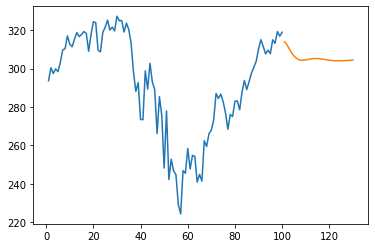

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

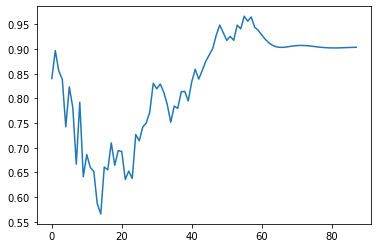

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

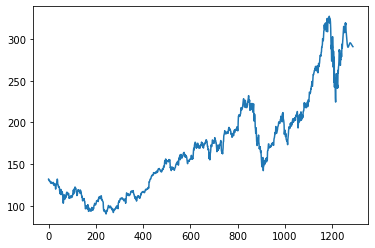

In [ ]:
plt.plot(df3)